#     Using Machine Learning to Diagnose Breast Cancer in Python
## by:  Steven Smiley

# Problem Statement:

Find a Machine Learning (ML) model that accurately predicts breast cancer based on the 30 features described below.

# 1.  Background:

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server: ftp ftp.cs.wisc.edu cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

* a) radius (mean of distances from center to points on the perimeter) 
* b) texture (standard deviation of gray-scale values) 
* c) perimeter 
* d) area 
* e) smoothness (local variation in radius lengths) 
* f) compactness (perimeter^2 / area - 1.0) 
* g) concavity (severity of concave portions of the contour) 
* h) concave points (number of concave portions of the contour) 
* i) symmetry 
* j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

# 2. Abstract:

  When it comes to diagnosing breast cancer, we want to make sure we don't have too many false-positives (you don't have cancer, but told you do and go on treatment) or false-negatives (you have cancer, but told you don't and don't get treatment). Therefore, the highest overall accuracy model is chosen.  
  
  The Data was split into 80% training (~455 people) and 20% testing (~114 people).
  
  Several different models were evaluated through k-fold Cross-Validation with GridSearchCV, which iterates on different algorithm's hyperparameters:
  * Logistic Regression 
  * Support Vector Machine
  * Neural Network
  * Random Forest
  * Gradient Boost
  * eXtreme Gradient Boost


 All of the models performed well after fine tunning their hyperparameters, but the best model is the one the highest overall accuracy.  Out of the 20% of data witheld in this test (114 random individuals), only a handful were misdiagnosed.  No model is perfect, but I am happy about how accurate my model is here.  If on average less than a handful of people out of 114 are misdiagnosed, that is a good start for making a model.  Furthermore, the Feature Importance plots show that the "concave points worst" and "concave points mean" were the significant features.  Therefore, I recommend the concave point features should be extracted from each future biopsy as a strong predictor for diagnosing breast cancer.   



# 3.  Import Libraries 

In [1]:
import warnings
import os # Get Current Directory
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd # data processing, CSV file I/O (e.i. pd.read_csv)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from scipy import stats
import subprocess
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
import itertools
from sklearn.preprocessing import StandardScaler

## Hide Warnings

In [2]:
warnings.filterwarnings("ignore")
pd.set_option('mode.chained_assignment', None)

## Get Current Directory

In [3]:
currentDirectory=os.getcwd()
print(currentDirectory)

/Users/stevensmiley/Documents/GitHub/BreastCancer


## Make Directorys for Output Files

#### Function: folder_path

In [4]:
def folder_path(path):
    try:
        os.mkdir(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
        return(path)
    else:
        print ("Successfully created the directory %s " % path)
        return(path)
    return(path)

In [5]:
# OUTPUTS: Folder for storing OUTPUTS
OUTPUT_path=folder_path(currentDirectory+'/Outputs')

# Models: Folder for storing models
models_path=folder_path(OUTPUT_path+'/Models')
# Figures: Folder for storing figures
figures_path=folder_path(OUTPUT_path+'/Figures')

Creation of the directory /Users/stevensmiley/Documents/GitHub/BreastCancer/Outputs failed
Creation of the directory /Users/stevensmiley/Documents/GitHub/BreastCancer/Outputs/Models failed
Creation of the directory /Users/stevensmiley/Documents/GitHub/BreastCancer/Outputs/Figures failed


# 4. Import and View Data

In [6]:
try:
    data= pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv')
except OSError:
    print ("Input file not found at location:",'/kaggle/input/breast-cancer-wisconsin-data/data.csv')
    data_path=os.path.join(currentDirectory,'data.csv')
    data= pd.read_csv(data_path)
    print ("Successfully loaded Input file from:",data_path)
else:
    print ("Successfully loaded Input file from:",'/kaggle/input/breast-cancer-wisconsin-data/data.csv')


data.head(10) # view the first 10 columns

Input file not found at location: /kaggle/input/breast-cancer-wisconsin-data/data.csv
Successfully loaded Input file from: /Users/stevensmiley/Documents/GitHub/BreastCancer/data.csv


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NaN
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,NaN
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,NaN


## 4.1 Import and View Data:  Check for Missing Values

As the background stated, no missing values should be present.  The following verifies that.  The last column doesn't hold any information and should be removed.  In addition, the diagnosis should be changed to a binary classification of 0= benign and 1=malignant.

In [7]:
data.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [8]:
# Drop Unnamed: 32 variable that has NaN values.
data.drop(['Unnamed: 32'],axis=1,inplace=True)

In [9]:
# Convert Diagnosis for Cancer from Categorical Variable to Binary
diagnosis_num={'B':0,'M':1}
data['diagnosis']=data['diagnosis'].map(diagnosis_num)

In [10]:
# Verify Data Changes, look at first 5 rows 
data.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## 4.2  Heatmap with Pearson Correlation Coefficient  for Features
A strong correlation is indicated by a Pearson Correlation Coefficient value near 1.  Therefore, when looking at the Heatmap, we want to see what correlates most with the first column, "diagnosis."  It appears that the features of "concave points worst" [0.79] has the strongest correlation with "diagnosis".  

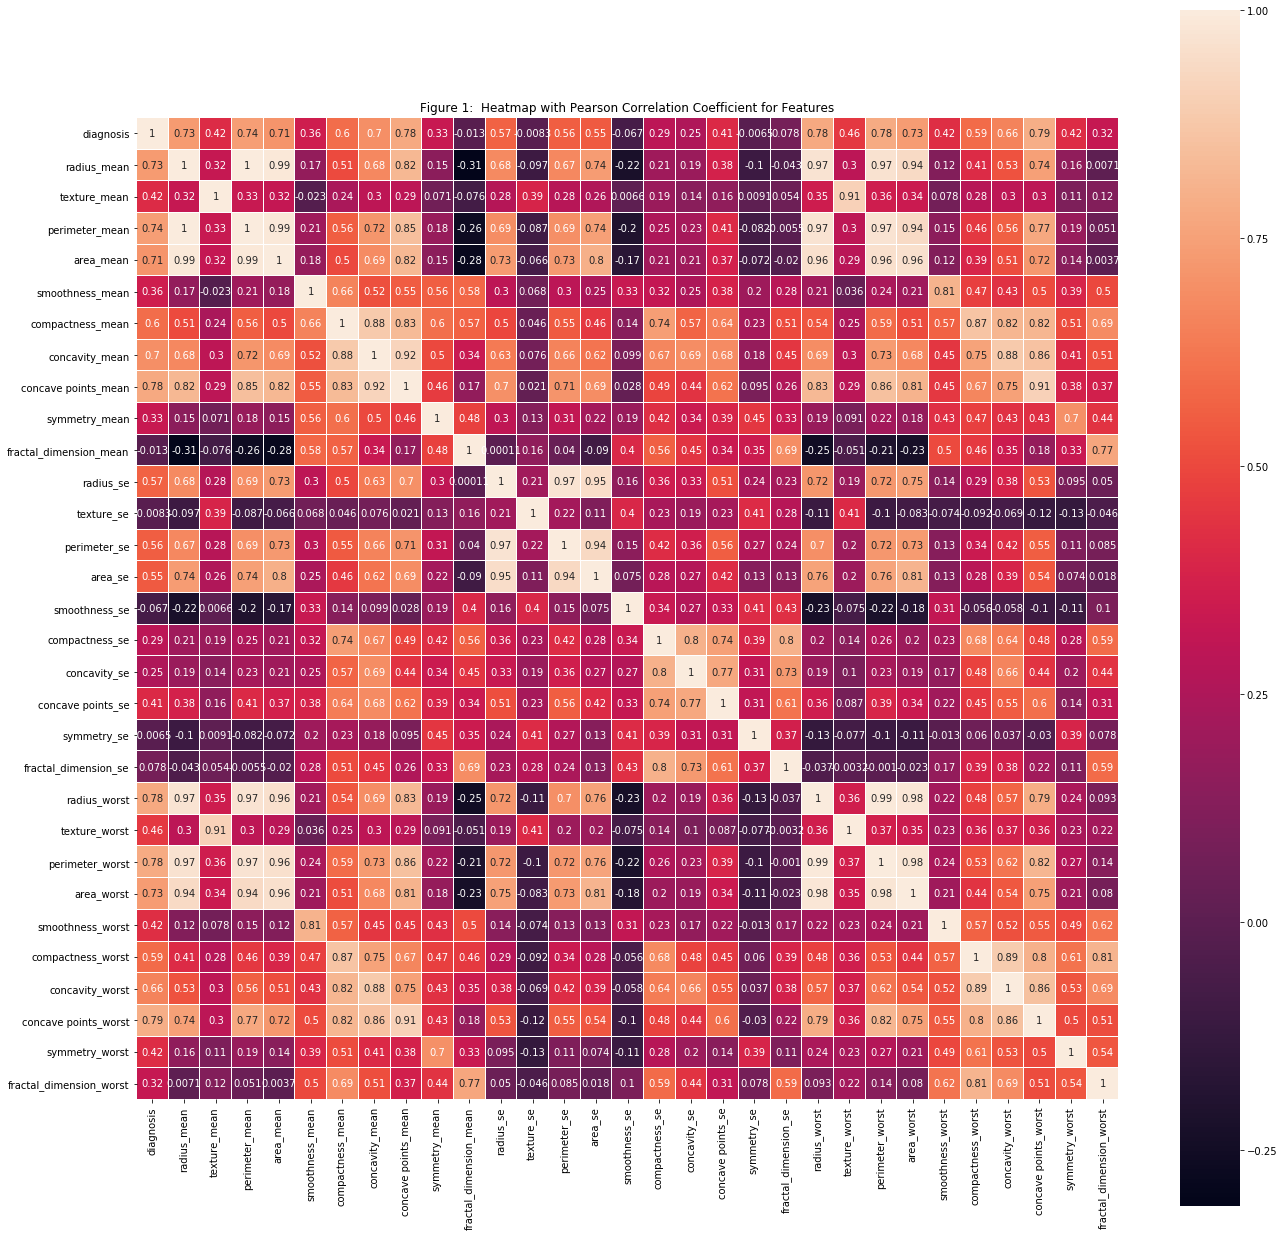

In [11]:
#fix,ax = plt.subplots(figsize=(25,25))
fix,ax = plt.subplots(figsize=(22,22))
heatmap_data = data.drop(['id'],axis=1)
sns.heatmap(heatmap_data.corr(),vmax=1,linewidths=0.01,square=True,annot=True,linecolor="white")
bottom,top=ax.get_ylim()
ax.set_ylim(bottom+0.5,top-0.5)
heatmap_title='Figure 1:  Heatmap with Pearson Correlation Coefficient for Features'
ax.set_title(heatmap_title)
heatmap_fig=os.path.join(figures_path,'Figure1.Heatmap.png')
plt.savefig(heatmap_fig,dpi=300,bbox_inches='tight')
plt.show()

# 5.  Split Data for Training  

## 5.1 Split Data for Training : Standardize and Split the Data

In [12]:
X = data.drop(['id','diagnosis'], axis= 1)
y = data.diagnosis

#Standardize Data
scaler = StandardScaler()
X=StandardScaler().fit_transform(X.values)
X = pd.DataFrame(X)
X.columns=(data.drop(['id','diagnosis'], axis= 1)).columns

A good rule of thumb is to hold out 20 percent of the data for testing. 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)


#Standardize Data
scaler = StandardScaler()

#Fit on training set only.
scaler.fit(X_train)

#Apply transform to both the training and test set
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)



## 5.2 Split Data for Training: Feature Extraction with PCA

In [14]:
#  Feature Extraction:  Principal Component Analysis: PC1, PC2
pca = PCA(n_components=2, random_state=42) 
# Only fit to the training set
pca.fit((X_train))
# transform with PCA model from training
principalComponents_train = pca.transform(X_train)
principalComponents_test = pca.transform(X_test)

# Use Pandas DataFrame
X_train = pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)
X_train.columns=(data.drop(['id','diagnosis'], axis= 1)).columns
X_test.columns=(data.drop(['id','diagnosis'], axis= 1)).columns
y_train = pd.DataFrame(y_train)
y_test=pd.DataFrame(y_test)

X_train['PC1']=principalComponents_train[:,0]
X_train['PC2']=principalComponents_train[:,1]
X_test['PC1']=principalComponents_test[:,0]
X_test['PC2']=principalComponents_test[:,1]

In [15]:
tr_features=X_train
tr_labels=y_train

val_features = X_test
val_labels=y_test

## 5.3 Split Data for Training:  Verify the Split

Verify the data was split correctly

In [16]:
print('X_train - length:',len(X_train), 'y_train - length:',len(y_train))
print('X_test - length:',len(X_test),'y_test - length:',len(y_test))
print('Percent heldout for testing:', round(100*(len(X_test)/len(data)),0),'%')

X_train - length: 455 y_train - length: 455
X_test - length: 114 y_test - length: 114
Percent heldout for testing: 20.0 %


# 6. Machine Learning:

In order to find a good model, several algorithms are tested on the training dataset. A senstivity study using different Hyperparameters of the algorithms are iterated on with GridSearchCV in order optimize each model. The best model is the one that has the highest accuracy without overfitting by looking at both the training data and the validation data results. Computer time does not appear to be an issue for these models, so it has little weight on deciding between models.

## GridSearch CV

class sklearn.model_selection.GridSearchCV(estimator, param_grid, scoring=None, n_jobs=None, iid='deprecated', refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)[source]¶

Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.

GridSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

#### Function: print_results

In [17]:
def print_results(results,name,filename_pr):
    with open(filename_pr, mode='w') as file_object:
        print(name,file=file_object)
        print(name)
        print('BEST PARAMS: {}\n'.format(results.best_params_),file=file_object)
        print('BEST PARAMS: {}\n'.format(results.best_params_))
        means = results.cv_results_['mean_test_score']
        stds = results.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, results.cv_results_['params']):
            print('{} {} (+/-{}) for {}'.format(name,round(mean, 3), round(std * 2, 3), params),file=file_object)
            print('{} {} (+/-{}) for {}'.format(name,round(mean, 3), round(std * 2, 3), params))

In [18]:
print(GridSearchCV)

<class 'sklearn.model_selection._search.GridSearchCV'>


# 6.1 Machine Learning Models:  Logistic Regression

## Logistic Regression:  Hyperparameter used in GridSearchCV
### HP1, C:  float, optional (default=1.0)
Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
##### Details
Regularization is when a penality is applied with increasing value to prevent overfitting.  The inverse of regularization strength means as the value of C goes up, the value of the regularization strength goes down and vice versa.  
##### Values chosen
'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [19]:
# Make Directory
path=folder_path(OUTPUT_path+'/Models/LR')

Creation of the directory /Users/stevensmiley/Documents/GitHub/BreastCancer/Outputs/Models/LR failed


In [20]:
LR_model_dir=os.path.join(path,'LR_model.pkl')
if os.path.exists(LR_model_dir) == False:
    lr = LogisticRegression()
    parameters = {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            }
    cv=GridSearchCV(lr, parameters, cv=5)
    cv.fit(tr_features,tr_labels.values.ravel())      
    print_results(cv,'Logistic Regression (LR)',os.path.join(path,'LR_GridSearchCV_results.txt'))
    cv.best_estimator_
    joblib.dump(cv.best_estimator_,LR_model_dir)
else:
    print('Already have LR')

Already have LR


# 6.2 Machine Learning Models:  Support Vector Machine

## Support Vector Machine:  
### Hyperparameter used in GridSearchCV
#### HP1,  kernelstring, optional (default=’rbf’)
Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape (n_samples, n_samples).
###### Details
A linear kernel type is good when the data is Linearly seperable, which means it can be separated by a single Line.
A radial basis function (rbf) kernel type is an expontential function of the squared Euclidean distance between two vectors and a constant.  Since the value of RBF kernel decreases with distance and ranges between zero and one, it has a ready interpretation as a similiarity measure.  
###### Values chosen
'kernel': ['linear','rbf']

#### HP2,  C:  float, optional (default=1.0)
Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.
###### Details
Regularization is when a penality is applied with increasing value to prevent overfitting.  The inverse of regularization strength means as the value of C goes up, the value of the regularization strength goes down and vice versa.  
###### Values chosen
'C': [0.1, 1, 10]

In [21]:
print(SVC())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


In [22]:
# Make Directory
path=folder_path(OUTPUT_path+'/Models/SVM')

Creation of the directory /Users/stevensmiley/Documents/GitHub/BreastCancer/Outputs/Models/SVM failed


In [23]:
SVM_model_dir=os.path.join(path,'SVM_model.pkl')
if os.path.exists(SVM_model_dir) == False:
    svc = SVC()
    parameters = {
            'kernel': ['linear','rbf'],
            'C': [0.1, 1, 10]
            }
    cv=GridSearchCV(svc,parameters, cv=5)
    cv.fit(tr_features, tr_labels.values.ravel())
    print_results(cv,'Support Vector Machine (SVM)',os.path.join(path,'SVM_GridSearchCV_results.txt'))
    cv.best_estimator_
    joblib.dump(cv.best_estimator_,SVM_model_dir)
else:
    print('Already have SVM')

Already have SVM


# 6.3 Machine Learning Models:  Neural Network

## Neural Network:  (sklearn)
### Hyperparameter used in GridSearchCV
#### HP1, hidden_layer_sizes:  tuple, length = n_layers - 2, default (100,)
The ith element represents the number of neurons in the ith hidden layer.
###### Details
A rule of thumb is (2/3)*(# of input features) = neurons per hidden layer. 
###### Values chosen
'hidden_layer_sizes': [(10,),(50,),(100,)]

#### HP2, activation:  {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default ‘relu’
Activation function for the hidden layer.
###### Details
* ‘identity’, no-op activation, useful to implement linear bottleneck, returns f(x) = x
* ‘logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
* ‘tanh’, the hyperbolic tan function, returns f(x) = tanh(x).
* ‘relu’, the rectified linear unit function, returns f(x) = max(0, x)   
###### Values chosen
'hidden_layer_sizes': [(10,),(50,),(100,)]

#### HP3, learning_rate:  {‘constant’, ‘invscaling’, ‘adaptive’}, default ‘constant’
Learning rate schedule for weight updates.
###### Details
* ‘constant’ is a constant learning rate given by ‘learning_rate_init’.
* ‘invscaling’ gradually decreases the learning rate at each time step ‘t’ using an inverse scaling exponent of ‘power_t’. effective_learning_rate = learning_rate_init / pow(t, power_t)
* ‘adaptive’ keeps the learning rate constant to ‘learning_rate_init’ as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if ‘early_stopping’ is on, the current learning rate is divided by 5.

Only used when solver='sgd'.
  
###### Values chosen
'learning_rate': ['constant','invscaling','adaptive']

In [24]:
print(MLPClassifier())

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)


In [25]:
# Make Directory
path=folder_path(OUTPUT_path+'/Models/MLP')

Creation of the directory /Users/stevensmiley/Documents/GitHub/BreastCancer/Outputs/Models/MLP failed


In [26]:
MLP_model_dir=os.path.join(path,'MLP_model.pkl')
if os.path.exists(MLP_model_dir) == False:
    mlp = MLPClassifier()
    parameters = {
            'hidden_layer_sizes': [(10,),(50,),(100,)],
            'activation': ['relu','tanh','logistic'],
            'learning_rate': ['constant','invscaling','adaptive']
            }
    cv=GridSearchCV(mlp, parameters, cv=5)
    cv.fit(tr_features, tr_labels.values.ravel())
    print_results(cv,'Neural Network (MLP)',os.path.join(path,'MLP_GridSearchCV_results.txt'))
    cv.best_estimator_
    joblib.dump(cv.best_estimator_,MLP_model_dir)
else:
    print('Already have MLP')

Already have MLP


# 6.4 Machine Learning Models:  Random Forest

## Random Forest:  
### Hyperparameter used in GridSearchCV
#### HP1, n_estimators:  integer, optional (default=100)
The number of trees in the forest.

Changed in version 0.22: The default value of n_estimators changed from 10 to 100 in 0.22.
###### Details
Usually 500 does the trick and the accuracy and out of bag error doesn't change much after. 
###### Values chosen
'n_estimators': [500],

#### HP2, max_depth:  integer or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
###### Details
None usually does the trick, but a few shallow trees are tested. 
###### Values chosen
'max_depth': [5,7,9, None]

In [27]:
print(RandomForestClassifier())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [28]:
# Make Directory
path=folder_path(OUTPUT_path+'/Models/RF')

Creation of the directory /Users/stevensmiley/Documents/GitHub/BreastCancer/Outputs/Models/RF failed


In [29]:
RF_model_dir=os.path.join(path,'RF_model.pkl')
if os.path.exists(RF_model_dir) == False:
    rf = RandomForestClassifier(oob_score=False)
    parameters = {
            'n_estimators': [500],
            'max_depth': [5,7,9, None]
            }
    cv = GridSearchCV(rf, parameters, cv=5)
    cv.fit(tr_features, tr_labels.values.ravel())
    print_results(cv,'Random Forest (RF)',os.path.join(path,'RF_GridSearchCV_results.txt'))
    cv.best_estimator_
    joblib.dump(cv.best_estimator_,RF_model_dir)
else:
    print('Already have RF')

Already have RF


# 6.5 Machine Learning Models:  Gradient Boosting

## Gradient Boosting:  
### Hyperparameter used in GridSearchCV
#### HP1, n_estimators:  int (default=100)
The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
###### Details
Usually 500 does the trick and the accuracy and out of bag error doesn't change much after. 
###### Values chosen
'n_estimators': [5, 50, 250, 500],

#### HP2, max_depth:  integer, optional (default=3)
maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables.
###### Details
A variety of shallow trees are tested. 
###### Values chosen
'max_depth': [1, 3, 5, 7, 9],

#### HP3, learning_rate:  float, optional (default=0.1)
learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.
###### Details
A variety was chosen because of the trade-off.
###### Values chosen
'learning_rate': [0.01, 0.1, 1]

In [30]:
print(GradientBoostingClassifier())

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [31]:
# Make Directory
path=folder_path(OUTPUT_path+'/Models/GB')

Creation of the directory /Users/stevensmiley/Documents/GitHub/BreastCancer/Outputs/Models/GB failed


In [32]:
GB_model_dir=os.path.join(path,'GB_model.pkl')
if os.path.exists(GB_model_dir) == False:
    gb = GradientBoostingClassifier()
    parameters = {
            'n_estimators': [5, 50, 250, 500],
            'max_depth': [1, 3, 5, 7, 9],
            'learning_rate': [0.01, 0.1, 1]
            }
    cv=GridSearchCV(gb, parameters, cv=5)
    cv.fit(tr_features, tr_labels.values.ravel())
    print_results(cv,'Gradient Boost (GB)',os.path.join(path,'GR_GridSearchCV_results.txt'))
    cv.best_estimator_
    joblib.dump(cv.best_estimator_,GB_model_dir)
else:
    print('Already have GB') 

Already have GB


# 6.6 Machine Learning Models:  eXtreme Gradient Boosting

## eXtreme Gradient Boosting:  
### Hyperparameter used in GridSearchCV
#### HP1, n_estimators:  (int) – Number of trees to fit.
###### Details
Usually 500 does the trick and the accuracy and out of bag error doesn't change much after. 
###### Values chosen
'n_estimators': [5, 50, 250, 500],

#### HP2, max_depth:  (int) – 
Maximum tree depth for base learners.
###### Details
A variety of shallow trees are tested. 
###### Values chosen
'max_depth': [1, 3, 5, 7, 9],

#### HP3, learning_rate: (float) – 
Boosting learning rate (xgb’s “eta”)
###### Details
A variety was chosen because of the trade-off.
###### Values chosen
'learning_rate': [0.01, 0.1, 1]

In [33]:
# Make Directory
path=folder_path(OUTPUT_path+'/Models/XGB')

Creation of the directory /Users/stevensmiley/Documents/GitHub/BreastCancer/Outputs/Models/XGB failed


In [34]:
XGB_model_dir=os.path.join(path,'XGB_model.pkl')
if os.path.exists(XGB_model_dir) == False:
    xgb = XGBClassifier()
    parameters = {
            'n_estimators': [5, 50, 250, 500],
            'max_depth': [1, 3, 5, 7, 9],
            'learning_rate': [0.01, 0.1, 1]
            }
    cv=GridSearchCV(xgb, parameters, cv=5)
    cv.fit(tr_features, tr_labels.values.ravel())
    print_results(cv,'eXtreme Gradient Boost (XGB)',os.path.join(path,'XGB_GridSearchCV_results.txt'))
    cv.best_estimator_
    joblib.dump(cv.best_estimator_,XGB_model_dir)
else:
    print('Already have XGB')  

Already have XGB


# 7. Evaluate Models

In [35]:
## all models
models = {}

#for mdl in ['LR', 'SVM', 'MLP', 'RF', 'GB','XGB']:
for mdl in ['LR', 'SVM', 'MLP', 'RF', 'GB','XGB']:
    model_path=os.path.join(OUTPUT_path,'Models/{}/{}_model.pkl')
    models[mdl] = joblib.load(model_path.format(mdl,mdl))

#### Function: evaluate_model

In [36]:
def evaluate_model(fig_path,name, model, features, labels, y_test_ev, fc):
        CM_fig=os.path.join(fig_path,'Figure{}.A_{}_Confusion_Matrix.png'.format(fc,name))
        VI_fig=os.path.join(fig_path,'Figure{}.B_{}_Variable_Importance_Plot.png'.format(fc,name))
        
        start = time()
        pred = model.predict(features)
        end = time()
        y_truth=y_test_ev
        accuracy = round(accuracy_score(labels, pred), 3)
        precision = round(precision_score(labels, pred), 3)
        recall = round(recall_score(labels, pred), 3)
        print('{} -- Accuracy: {} / Precision: {} / Recall: {} / Latency: {}ms'.format(name,
                                                                                       accuracy,
                                                                                       precision,
                                                                                       recall,
                                                                                       round((end - start)*1000, 1)))
        
        
        pred=pd.DataFrame(pred)
        pred.columns=['diagnosis']
        # Convert Diagnosis for Cancer from Binary to Categorical
        diagnosis_name={0:'Benign',1:'Malginant'}
        y_truth['diagnosis']=y_truth['diagnosis'].map(diagnosis_name)
        pred['diagnosis']=pred['diagnosis'].map(diagnosis_name)
        class_names = ['Benign','Malginant']        
        cm = confusion_matrix(y_test_ev, pred, class_names)
        
        FP_L='False Positive'
        FP = cm[0][1]
        FN_L='False Negative'
        FN = cm[1][0]
        TP_L='True Positive'
        TP = cm[1][1]
        TN_L='True Negative'
        TN = cm[0][0]

        #TPR_L= 'Sensitivity, hit rate, recall, or true positive rate'
        TPR_L= 'Sensitivity'
        TPR = round(TP/(TP+FN),3)
        #TNR_L= 'Specificity or true negative rate'
        TNR_L= 'Specificity'
        TNR = round(TN/(TN+FP),3) 
        #PPV_L= 'Precision or positive predictive value'
        PPV_L= 'Precision'
        PPV = round(TP/(TP+FP),3)
        #NPV_L= 'Negative predictive value'
        NPV_L= 'NPV'
        NPV = round(TN/(TN+FN),3)
        #FPR_L= 'Fall out or false positive rate'
        FPR_L= 'FPR'
        FPR = round(FP/(FP+TN),3)
        #FNR_L= 'False negative rate'
        FNR_L= 'FNR'
        FNR = round(FN/(TP+FN),3)
        #FDR_L= 'False discovery rate'
        FDR_L= 'FDR'
        FDR = round(FP/(TP+FP),3)

        ACC_L= 'Accuracy'
        ACC = round((TP+TN)/(TP+FP+FN+TN),3)
        
        stats_data = {'Name':name,
                     ACC_L:ACC,
                     FP_L:FP,
                     FN_L:FN,
                     TP_L:TP,
                     TN_L:TN,
                     TPR_L:TPR,
                     TNR_L:TNR,
                     PPV_L:PPV,
                     NPV_L:NPV,
                     FPR_L:FPR,
                     FNR_L:FDR}
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm,cmap=plt.cm.gray_r)
        plt.title('Figure {}.A: {} Confusion Matrix on Unseen Test Data'.format(fc,name),y=1.08)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        # Loop over data dimensions and create text annotations.
        for i in range(len(class_names)):
            for j in range(len(class_names)):
                text = ax.text(j, i, cm[i, j],
                               ha="center", va="center", color="r")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(CM_fig,dpi=400,bbox_inches='tight')
        #plt.show()
        
        if  name == 'RF' or name == 'GB' or name == 'XGB': 
            # Get numerical feature importances
            importances = list(model.feature_importances_)
            importances=100*(importances/max(importances))               
            feature_list = list(features.columns)
            sorted_ID=np.argsort(importances)   
            plt.figure(figsize=[10,10])
            plt.barh(sort_list(feature_list,importances),importances[sorted_ID],align='center')
            plt.title('Figure {}.B: {} Variable Importance Plot'.format(fc,name))
            plt.xlabel('Relative Importance')
            plt.ylabel('Feature') 
            plt.savefig(VI_fig,dpi=300,bbox_inches='tight')
            #plt.show()
        
        return accuracy,name, model, stats_data
        



#### Function:  sort_list

In [37]:
    def sort_list(list1, list2): 
        zipped_pairs = zip(list2, list1)   
        z = [x for _, x in sorted(zipped_pairs)]       
        return z 

### Search for best model using test features

LR -- Accuracy: 0.991 / Precision: 1.0 / Recall: 0.977 / Latency: 1.6ms
SVM -- Accuracy: 0.982 / Precision: 1.0 / Recall: 0.953 / Latency: 0.9ms
MLP -- Accuracy: 0.974 / Precision: 0.976 / Recall: 0.953 / Latency: 9.2ms
RF -- Accuracy: 0.965 / Precision: 0.976 / Recall: 0.93 / Latency: 48.8ms
GB -- Accuracy: 0.956 / Precision: 0.952 / Recall: 0.93 / Latency: 2.1ms
XGB -- Accuracy: 0.965 / Precision: 0.953 / Recall: 0.953 / Latency: 2.2ms


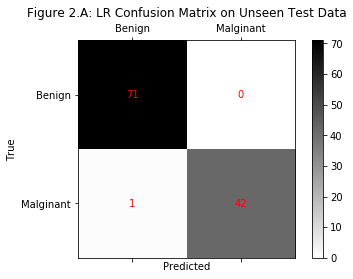

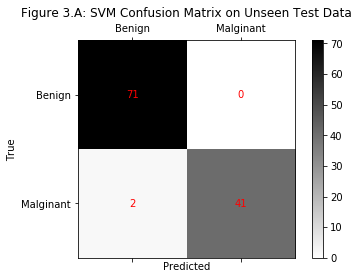

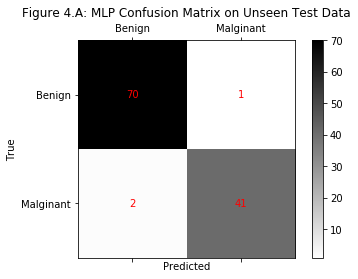

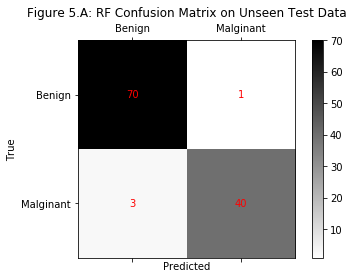

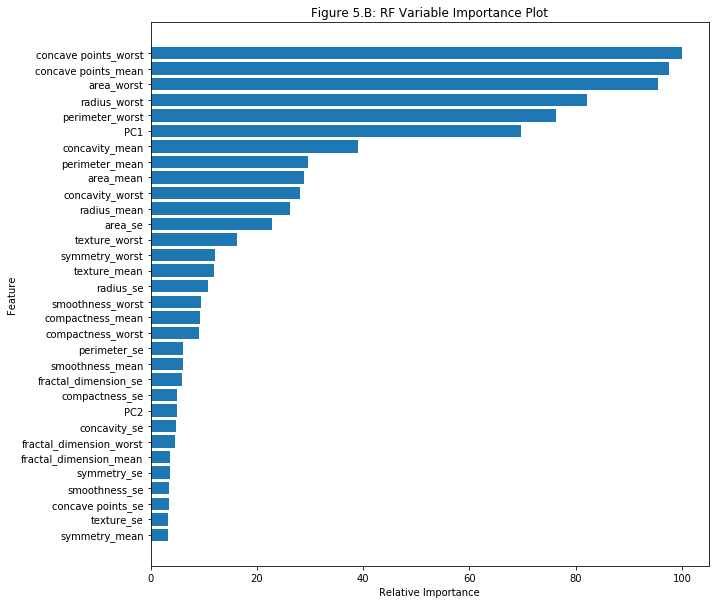

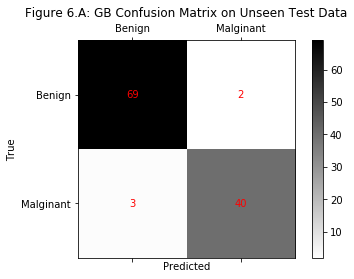

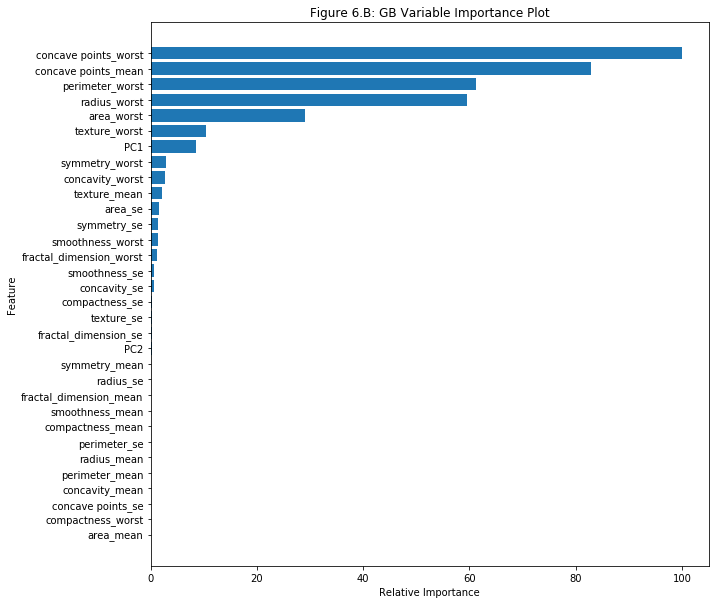

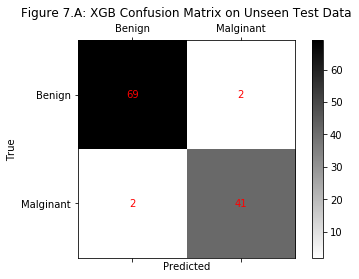

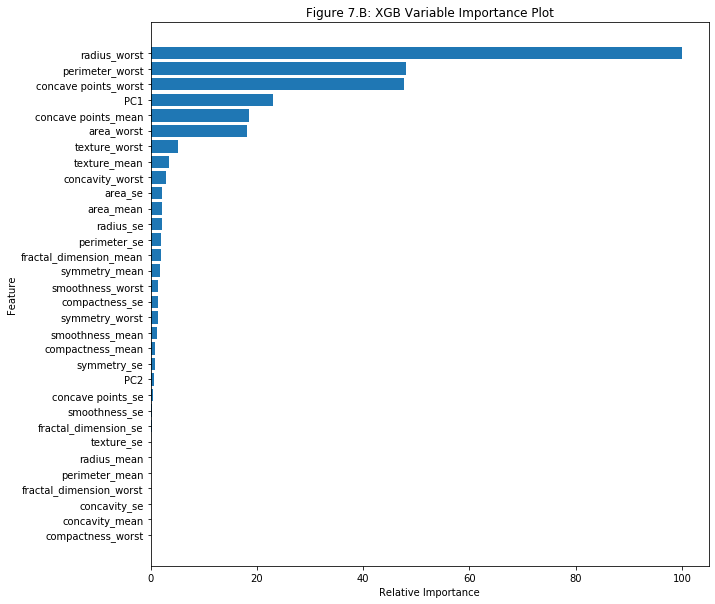

In [38]:
ev_accuracy=[None]*len(models)
ev_name=[None]*len(models)
ev_model=[None]*len(models)
ev_stats=[None]*len(models)
count=1
for name, mdl in models.items():
        y_test_ev=y_test
        ev_accuracy[count-1],ev_name[count-1],ev_model[count-1], ev_stats[count-1] = evaluate_model(figures_path,
                                                                                                    name,
                                                                                                    mdl,
                                                                                                    val_features,
                                                                                                    val_labels,
                                                                                                    y_test_ev,
                                                                                                    count+1)
        diagnosis_name={'Benign':0,'Malginant':1}
        y_test['diagnosis']=y_test['diagnosis'].map(diagnosis_name)
        count=count+1

    



In [39]:
best_name=ev_name[ev_accuracy.index(max(ev_accuracy))]    #picks the maximum accuracy
print('Best Model:',best_name,'with Accuracy of ',max(ev_accuracy))   
best_model=ev_model[ev_accuracy.index(max(ev_accuracy))]    #picks the maximum accuracy

if best_name == 'RF' or best_name == 'GB' or best_name == 'XGB': 
    # Get numerical feature importances
    importances = list(best_model.feature_importances_)
    importances=100*(importances/max(importances))               
    feature_list = list(X.columns)
    sorted_ID=np.argsort(importances)   
    plt.figure(figsize=[10,10])
    plt.barh(sort_list(feature_list,importances),importances[sorted_ID],align='center')
    plt.title('Figure 8:  Variable Importance Plot -- {}'.format(best_name))
    plt.xlabel('Relative Importance')
    plt.ylabel('Feature') 
    plt.savefig(os.path.join(figures_path,'Figure8.png'),dpi=300,bbox_inches='tight')
    plt.show()

Best Model: LR with Accuracy of  0.991


 # 8. Conclusions 
  When it comes to diagnosing breast cancer, we want to make sure we don't have too many false-positives (you don't have cancer, but told you do and go on treatment) or false-negatives (you have cancer, but told you don't and don't get treatment). Therefore, the highest overall accuracy model is chosen.  

  All of the models performed well after fine tunning their hyperparameters, but the best model is the one the highest overall accuracy.  Out of the 20% of data witheld in this test (114 random individuals), only a handful were misdiagnosed.  No model is perfect, but I am happy about how accurate my model is here.  If on average less than a handful of people out of 114 are misdiagnosed, that is a good start for making a model.  Furthermore, the Feature Importance plots show that the "concave points worst" and "concave points mean" were the significant features.  Therefore, I recommend the concave point features should be extracted from each future biopsy as a strong predictor for diagnosing breast cancer.   

In [40]:
ev_stats=pd.DataFrame(ev_stats)
print(ev_stats.head(10))

  Name  Accuracy  False Positive  False Negative  True Positive  \
0   LR     0.991               0               1             42   
1  SVM     0.982               0               2             41   
2  MLP     0.974               1               2             41   
3   RF     0.965               1               3             40   
4   GB     0.956               2               3             40   
5  XGB     0.965               2               2             41   

   True Negative  Sensitivity  Specificity  Precision    NPV    FPR    FNR  
0             71        0.977        1.000      1.000  0.986  0.000  0.000  
1             71        0.953        1.000      1.000  0.973  0.000  0.000  
2             70        0.953        0.986      0.976  0.972  0.014  0.024  
3             70        0.930        0.986      0.976  0.959  0.014  0.024  
4             69        0.930        0.972      0.952  0.958  0.028  0.048  
5             69        0.953        0.972      0.953  0.972  0.028 